<a href="https://colab.research.google.com/github/AnitaTasnim/GNN_attack_model/blob/main/gnn_target_attack_cora_using_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygod
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygod: filename=pygod-1.0.0-py3-none-any.whl size=70678 sha256=ed64aa45042a02d33287c51c4850d2ec46f689eaa5425164bdd3a83979947fbf
  Stored in directory: /root/.cache/pip/wheels/19/4f/5e/d4a08c3476915cb8021462fe4129680c598ebce8b100f59ecf
Successfully built pygod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=86045b1dd01bdf67fecfc38e4cbc5bb7d4f0114394df7d19a036f84e260d0900
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch_geometric
from pygod.utils import load_data
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
pwd

'/kaggle/working'

In [ ]:
import torch
from torch_geometric.datasets import Planetoid

# Load the CORA dataset
dataset = Planetoid(root='/kaggle/working', name='Cora')

# Get the adjacency matrix, features, and labels
adj = dataset[0].edge_index.t()
features = dataset[0].x
labels = dataset[0].y

# Get the train, validation, and test indices
idx_train = dataset[0].train_mask.nonzero().view(-1)
idx_val = dataset[0].val_mask.nonzero().view(-1)
idx_test = dataset[0].test_mask.nonzero().view(-1)

# Print some dataset statistics
print(f"Number of nodes: {adj.size(0)}")
print(f"Number of edges: {adj.sum().item() // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features per node: {features.size(1)}")
print(f"Number of classes: {int(labels.max()) + 1}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")


Processing...


Number of nodes: 10556
Number of edges: 13820218
Number of features per node: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


Done!


In [ ]:
import numpy as np
idx_unlabeled = np.union1d(idx_val, idx_test)
idx_unlabeled[:10]

array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

In [ ]:
import random
target_number = 10
node_list = random.sample(list(idx_unlabeled),target_number)
node_list

[1997, 2576, 2500, 563, 2276, 2459, 2446, 2029, 359, 2129]

In [ ]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device

device(type='cuda')

In [ ]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x



In [ ]:
degree_cora = {}
for (u, v) in adj:
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

degree_cora[400]

1

In [ ]:
node_list

[1997, 2576, 2500, 563, 2276, 2459, 2446, 2029, 359, 2129]

Epoch 500/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.5386, Validation Accuracy: 0.6380, Validation Precision: 0.6380, Validation Recall: 0.6380
Test Loss: 1.5096, Test Accuracy: 0.6700, Test Precision: 0.6700, Test Recall: 0.6700

Epoch 1000/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.5571, Validation Accuracy: 0.6420, Validation Precision: 0.6420, Validation Recall: 0.6420
Test Loss: 1.5076, Test Accuracy: 0.6590, Test Precision: 0.6590, Test Recall: 0.6590

Epoch 1500/5000:
Train Loss: 1.1672, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000
Validation Loss: 1.4757, Validation Accuracy: 0.6760, Validation Precision: 0.6760, Validation Recall: 0.6760
Test Loss: 1.4642, Test Accuracy: 0.7160, Test Precision: 0.7160, Test Recall: 0.7160

Epoch 2000/5000:
Train Loss: 1.1655, Train Accuracy: 1.0000, Train Precision: 1.0000, Tra

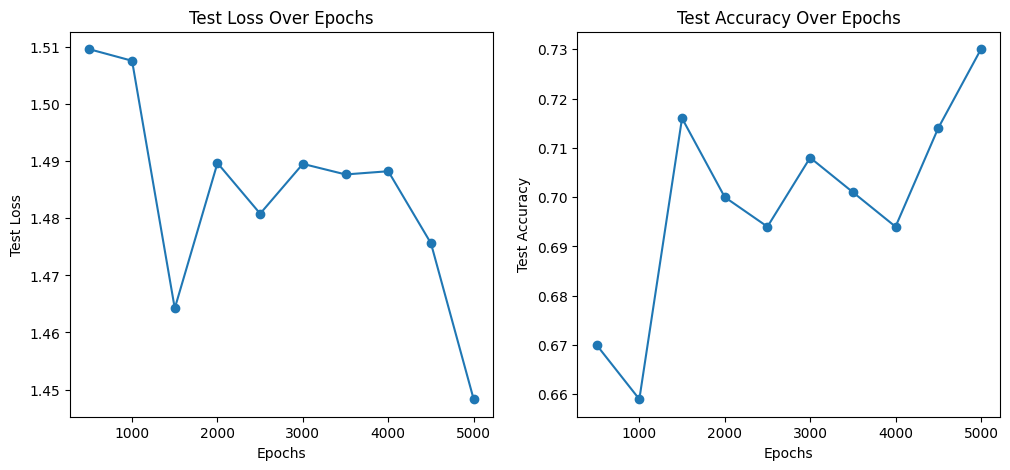

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Initialize the model and optimizer
num_features = features.size(1)
num_classes = int(labels.max()) + 1
hidden_channels = 64  # You can adjust this as needed
model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a function for evaluation
def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average='micro')
        recall = recall_score(labels, pred, average='micro')
        return accuracy, precision, recall

# Training loop
num_epochs = 5000
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(features, adj.t())
    loss = F.cross_entropy(logits[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        train_loss = loss.item()
        val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
        test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

        train_accuracy, train_precision, train_recall = evaluate(model, features,adj,labels, idx_train)
        val_accuracy, val_precision, val_recall = evaluate(model, features,adj,labels, idx_val)
        test_accuracy, test_precision, test_recall = evaluate(model, features,adj,labels, idx_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        print("")


# Plot test loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(500, num_epochs + 1, 500), test_losses, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(500, num_epochs + 1, 500), test_accuracies, marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()


In [ ]:
pwd

'/kaggle/working'

### Autoencoder

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.nn import GAE, VGAE, GCNConv
import time

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])


In [ ]:
dataset = torch_geometric.datasets.Planetoid('/kaggle/working/',name='Cora',transform=transform)
train_data, val_data, test_data = dataset[0]


In [ ]:
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488])

In [ ]:
val_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[263], pos_edge_label_index=[2, 263], neg_edge_label=[263], neg_edge_label_index=[2, 263])

In [ ]:
test_data

Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [ ]:
in_channels, out_channels = dataset.num_features, 16


In [ ]:
threshold = 0.90

### GAE

In [ ]:
model_2 = GAE(GCNEncoder(in_channels, out_channels))

In [ ]:
model_2 = model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
epochs = 1000
variational = False

In [ ]:
def train():
    model_2.train()
    optimizer.zero_grad()
    z = model_2.encode(train_data.x, train_data.edge_index)
    loss = model_2.recon_loss(z, train_data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model_2.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model_2.eval()
    z = model_2.encode(data.x, data.edge_index)
    return model_2.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 100, AUC: 0.8764, AP: 0.8770
Epoch: 200, AUC: 0.8837, AP: 0.8857
Epoch: 300, AUC: 0.8852, AP: 0.8893
Epoch: 400, AUC: 0.8922, AP: 0.8967
Epoch: 500, AUC: 0.8939, AP: 0.9001
Epoch: 600, AUC: 0.8977, AP: 0.9034
Epoch: 700, AUC: 0.8982, AP: 0.9047
Epoch: 800, AUC: 0.8966, AP: 0.9048
Epoch: 900, AUC: 0.8939, AP: 0.9038
Epoch: 1000, AUC: 0.8952, AP: 0.9062
Median time per epoch: 0.0176s


In [ ]:
model_2

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1433, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [ ]:
dataset = torch_geometric.datasets.Planetoid('/kaggle/working/',name='Cora',transform=NormalizeFeatures())
graph_cora = dataset[0]

encoded = model_2.encode(graph_cora.x.to(device), graph_cora.edge_index.to(device))
encoded

tensor([[-0.1899, -0.4869,  0.2445,  ..., -0.4578,  0.8565,  0.0322],
        [ 0.6245,  0.1098, -0.1040,  ...,  0.4304, -0.1734, -0.4905],
        [ 0.2186,  0.2524,  0.2767,  ...,  0.1836,  0.1136, -0.2753],
        ...,
        [ 0.0872,  0.1299,  0.9815,  ..., -0.2758, -0.1250,  0.7535],
        [-0.3154, -0.2417,  0.1247,  ..., -0.2273,  0.7926, -0.1933],
        [-0.4411, -0.3738,  0.0915,  ..., -0.2465,  0.7796, -0.2253]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
decoded = model_2.decoder(encoded, graph_cora.edge_index)
decoded.shape

torch.Size([10556])

In [ ]:
type(graph_cora.edge_index[0])

torch.Tensor

In [ ]:
reshaped_edge_index = torch.transpose(graph_cora.edge_index, 0, 1)
decoded_edge_index_list = []
for i in range(len(decoded)):
    if decoded[i] > threshold:
#         print(reshaped_edge_index[i])
        decoded_edge_index_list.append(list(reshaped_edge_index[i]))

decoded_edge_index = torch.tensor(decoded_edge_index_list, dtype=torch.long).t()
len(decoded_edge_index[0])

8666

### VGAE

In [ ]:
model_3 = VGAE(VariationalGCNEncoder(in_channels, out_channels))
model_3

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(1433, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [ ]:
model_3 = model_3.to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
epochs = 1000
variational = True

In [ ]:
def train():
    model_3.train()
    optimizer.zero_grad()
    z = model_3.encode(train_data.x, train_data.edge_index)
    loss = model_3.recon_loss(z, train_data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model_3.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model_3.eval()
    z = model_3.encode(data.x, data.edge_index)
    return model_3.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 100, AUC: 0.7261, AP: 0.7328
Epoch: 200, AUC: 0.8813, AP: 0.8845
Epoch: 300, AUC: 0.8896, AP: 0.8918
Epoch: 400, AUC: 0.8994, AP: 0.9016
Epoch: 500, AUC: 0.8998, AP: 0.9036
Epoch: 600, AUC: 0.9033, AP: 0.9082
Epoch: 700, AUC: 0.9112, AP: 0.9155
Epoch: 800, AUC: 0.9110, AP: 0.9122
Epoch: 900, AUC: 0.9103, AP: 0.9125
Epoch: 1000, AUC: 0.9092, AP: 0.9134
Median time per epoch: 0.0199s


In [ ]:
encoded_2 = model_3.encode(graph_cora.x.to(device), graph_cora.edge_index.to(device))
encoded_2

tensor([[ 0.7977, -0.2589, -0.2008,  ...,  0.7228,  0.0833, -0.1654],
        [-0.6115,  0.6756, -0.5153,  ..., -0.2254, -0.0534,  0.1262],
        [-0.2230,  0.5235, -0.3752,  ...,  0.2747, -0.0300, -0.2567],
        ...,
        [ 0.3518, -0.1621, -0.1988,  ..., -0.2160,  0.1967, -0.1308],
        [ 0.1289,  0.1078, -0.1844,  ...,  0.4528,  0.2511, -0.4922],
        [ 0.2086, -0.0265, -0.1452,  ...,  0.3821,  0.3058, -0.4406]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
decoded_2 = model_3.decoder(encoded_2, graph_cora.edge_index)
decoded_2.shape

torch.Size([10556])

In [ ]:
reshaped_edge_index_2 = torch.transpose(graph_cora.edge_index, 0, 1)
decoded_edge_index_list_2 = []
for i in range(len(decoded_2)):
    if decoded_2[i] > threshold:
#         print(reshaped_edge_index[i])
        decoded_edge_index_list_2.append(list(reshaped_edge_index[i]))

decoded_edge_index_2 = torch.tensor(decoded_edge_index_list_2, dtype=torch.long).t()
len(decoded_edge_index_2[0])

7748

### edge_index analysis for most important edges

In [ ]:
edge_index_1 = decoded_edge_index
adj_list_1 = edge_index_1.t().tolist()
print(len(adj_list_1))

edge_index_2 = decoded_edge_index_2
adj_list_2 = edge_index_2.t().tolist()
print(len(adj_list_2))

8666
7748


In [ ]:
set1 = set(tuple(item) for item in adj_list_1)
set2 = set(tuple(item) for item in adj_list_2)

# Find the common elements using the intersection operation
common_elements = set1.intersection(set2)

# Convert the result back to a list of lists if needed
common_elements_list = [tuple(item) for item in common_elements]

# Print the common elements
print(len(common_elements_list))


7554


In [ ]:
node_list

[1997, 2576, 2500, 563, 2276, 2459, 2446, 2029, 359, 2129]

In [ ]:
node = node_list[0]
for (u, v) in common_elements_list:
    if u == node or v == node:
        print(f"{node} => ({u}, {v})")

1997 => (1986, 1997)
1997 => (1997, 1986)


### edge_index analysis for least important edges

In [ ]:
import networkx as nx
data = dataset[0]

# Create a NetworkX graph from the PyTorch Geometric data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Calculate node degrees
degrees = dict(G.degree())

# Find the node with the lowest degree
min_degree_node = min(degrees, key=degrees.get)
min_degree_value = degrees[min_degree_node]

print(f"Node {min_degree_node} has the lowest degree of {min_degree_value} in the Cora dataset.")


Node 654 has the lowest degree of 1 in the Cora dataset.


In [ ]:
# import networkx as nx
# import numpy as np
# from torch_geometric.datasets import Planetoid

# # Load the Cora dataset
# dataset = Planetoid(root='/kaggle/working', name='Cora')
# data = dataset[0]

# # Create a NetworkX graph from the PyTorch Geometric data
# G = nx.Graph()
# G.add_edges_from(data.edge_index.T.tolist())

# # Find the minimum degree in the Cora dataset
# min_degree_value = min(dict(G.degree()).values())

# # Find nodes with minimum degree and less geometric importance
# nodes_with_min_degree_and_less_importance = []
# for node in G.nodes():
#     if G.degree[node] == min_degree_value:
#         # Create a subgraph without the current node
#         subgraph = G.copy()
#         subgraph.remove_node(node)

#         # Calculate the Laplacian matrix for the subgraph manually
#         degree_sequence = list(dict(subgraph.degree()).values())
#         D = np.diag(degree_sequence)
#         A = nx.to_numpy_array(subgraph)
#         L_subgraph = D - A

#         # Compute the second smallest eigenvalue for the subgraph Laplacian
#         eigvals_subgraph = np.linalg.eig(L_subgraph)
#         second_smallest_eigval_subgraph = np.sort(eigvals_subgraph[0]).real

#         # Calculate geometric importance as the difference between global and subgraph eigenvalues
#         eigvals_global = np.linalg.eig(nx.to_numpy_array(G))
#         second_smallest_eigval_global = np.sort(eigvals_global[0]).real
#         geometric_importance = abs(second_smallest_eigval_global[0] - second_smallest_eigval_subgraph[0])

#         # Check if the node has less geometric importance
#         if geometric_importance < 1e-6:  # Adjust the threshold as needed
#             nodes_with_min_degree_and_less_importance.append(node)

# print("Nodes with minimum degree and less geometric importance:", nodes_with_min_degree_and_less_importance)


In [ ]:
import networkx as nx
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/kaggle/working', name='Cora')
data = dataset[0]

# Create a NetworkX graph from the PyTorch Geometric data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Find disconnected components in the graph
disconnected_components = list(nx.connected_components(G))

# Print the number of disconnected components and the size of each component
print(f"Number of disconnected components: {len(disconnected_components)}")
for i, component in enumerate(disconnected_components):
    print(f"Component {i + 1} size: {len(component)}")


Number of disconnected components: 78
Component 1 size: 2485
Component 2 size: 2
Component 3 size: 2
Component 4 size: 5
Component 5 size: 26
Component 6 size: 8
Component 7 size: 2
Component 8 size: 4
Component 9 size: 2
Component 10 size: 9
Component 11 size: 2
Component 12 size: 3
Component 13 size: 6
Component 14 size: 2
Component 15 size: 2
Component 16 size: 3
Component 17 size: 2
Component 18 size: 2
Component 19 size: 2
Component 20 size: 2
Component 21 size: 2
Component 22 size: 3
Component 23 size: 2
Component 24 size: 4
Component 25 size: 4
Component 26 size: 2
Component 27 size: 3
Component 28 size: 2
Component 29 size: 3
Component 30 size: 2
Component 31 size: 2
Component 32 size: 2
Component 33 size: 4
Component 34 size: 2
Component 35 size: 2
Component 36 size: 2
Component 37 size: 2
Component 38 size: 5
Component 39 size: 2
Component 40 size: 2
Component 41 size: 2
Component 42 size: 3
Component 43 size: 2
Component 44 size: 2
Component 45 size: 2
Component 46 size: 2
C

In [ ]:
# Find disconnected components in the graph
disconnected_components = list(nx.connected_components(G))

# Randomly select a node from each component
nodes_to_connect = []

for component in disconnected_components:
    random_node = random.choice(list(component))
    nodes_to_connect.append(random_node)

# Find nodes with different labels for the selected nodes
source_node = None
target_node = None

for node in nodes_to_connect:
    label = data.y[node].item()
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        if data.y[neighbor].item() != label:
            source_node = node
            target_node = neighbor
            break

print(source_node, target_node)

2660 1673


In [ ]:
common_elements_list[:20]

[(1169, 301),
 (2387, 638),
 (1256, 2175),
 (2070, 702),
 (1229, 1254),
 (1702, 1703),
 (1810, 482),
 (1334, 1950),
 (1986, 1876),
 (298, 1095),
 (1870, 1701),
 (1156, 897),
 (1464, 1013),
 (2059, 405),
 (316, 920),
 (1224, 1526),
 (1616, 2050),
 (1074, 1501),
 (1777, 426),
 (1529, 1115)]

In [ ]:
import networkx as nx
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/kaggle/working', name='Cora')
data = dataset[0]

# Create a NetworkX graph from the PyTorch Geometric data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

disconnected_components = list(nx.connected_components(G))

degree_cora = {}
for (u, v) in graph_cora.edge_index.t():
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

def modify_adj(target_node, adj, budget):

    degree = degree_cora.copy()

    prune_list = []
    for (u, v) in common_elements_list:
        if (u == target_node or v == target_node):
            if (u, v) not in prune_list:
                prune_list.append((u, v))
            if (v, u) not in prune_list:
                prune_list.append((v, u))

    final_prune_list = prune_list.copy()
    i = 0
    while i < len(prune_list):
        u, v = map(int, prune_list[i])

        if u in degree and degree[u] > 1:
            degree[u] -= 1
        else:
#             print('Okay')
            final_prune_list = [lst for lst in final_prune_list if lst != prune_list[i]]
            if prune_list[i] in final_prune_list:
                print("why here bro!")
        i += 1

    updated_edges = []
    cnt = 0
    for edge in adj:
        if budget == 0:
            updated_edges.append(edge.tolist())
        elif tuple(edge.tolist()) not in final_prune_list:
            updated_edges.append(edge.tolist())
        else:
            budget -= 1
            cnt += 1

    print(f"removed {cnt} edges.")

    if budget != 0:
        nodes_to_connect = []

        source_node = target_node
        label = labels[source_node]

        for component in disconnected_components:
            random_node = list(component)[0]
            if nx.node_connected_component(G, source_node) != nx.node_connected_component(G, random_node):
                i = 1
                while (label != labels[random_node]) and i < len(component):
                    random_node = list(component)[i]
                    i += 1
                if i != len(component):
                    nodes_to_connect.append(random_node)

        cnt = 0
        for node in nodes_to_connect:
            if budget == 0:
                break
            cnt += 1
            updated_edges.append([source_node, node])
            budget -= 1


        print(f"added {cnt} edges.")

    return torch.tensor(updated_edges, dtype=torch.long)

def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = torch.argmax(logits)
        accuracy = 1 if int(labels) == int(pred) else 0
        return accuracy

In [ ]:
import random
target_number = 50
node_list = random.sample(list(idx_unlabeled),target_number)
node_list

[2191,
 2139,
 2116,
 2520,
 2380,
 2470,
 2130,
 417,
 251,
 345,
 2275,
 388,
 278,
 423,
 1983,
 2507,
 566,
 282,
 622,
 2629,
 2227,
 387,
 2092,
 2575,
 552,
 162,
 418,
 1881,
 1850,
 2250,
 2592,
 559,
 1814,
 2267,
 372,
 2296,
 2373,
 2269,
 1967,
 1723,
 2313,
 580,
 1948,
 170,
 2347,
 1789,
 2387,
 391,
 326,
 1945]

### for modified dataset

In [ ]:
from tqdm import tqdm

budget = 7
cnt = 0
for target_node in node_list:
    print(f"=== For node: {target_node} ====")
    modified_adj = modify_adj(target_node, adj, budget)
    accuracy = evaluate(model, features, modified_adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print("============")
print('Miss-classification rate : %s' % (cnt / len(node_list)))

=== For node: 2191 ====
removed 0 edges.
added 7 edges.
Node: 2191, Accuracy: 0
=== For node: 2139 ====
removed 7 edges.
Node: 2139, Accuracy: 1
=== For node: 2116 ====
removed 0 edges.
added 3 edges.
Node: 2116, Accuracy: 0
=== For node: 2520 ====
removed 5 edges.
added 2 edges.
Node: 2520, Accuracy: 0
=== For node: 2380 ====
removed 5 edges.
added 2 edges.
Node: 2380, Accuracy: 1
=== For node: 2470 ====
removed 0 edges.
added 3 edges.
Node: 2470, Accuracy: 0
=== For node: 2130 ====
removed 7 edges.
Node: 2130, Accuracy: 1
=== For node: 417 ====
removed 4 edges.
added 3 edges.
Node: 417, Accuracy: 0
=== For node: 251 ====
removed 7 edges.
Node: 251, Accuracy: 1
=== For node: 345 ====
removed 1 edges.
added 6 edges.
Node: 345, Accuracy: 0
=== For node: 2275 ====
removed 4 edges.
added 3 edges.
Node: 2275, Accuracy: 1
=== For node: 388 ====
removed 2 edges.
added 5 edges.
Node: 388, Accuracy: 0
=== For node: 278 ====
removed 0 edges.
added 7 edges.
Node: 278, Accuracy: 1
=== For node: 4

### for original dataset

In [ ]:
from tqdm import tqdm

cnt = 0
for target_node in tqdm(node_list):
    accuracy = evaluate(model, features, adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print('Miss-classification rate : %s' % (cnt / len(node_list)))

  0%|          | 0/50 [00:00<?, ?it/s]

Node: 2191, Accuracy: 0
Node: 2139, Accuracy: 1
Node: 2116, Accuracy: 0
Node: 2520, Accuracy: 1


 20%|██        | 10/50 [00:00<00:00, 44.53it/s]

Node: 2380, Accuracy: 1
Node: 2470, Accuracy: 0
Node: 2130, Accuracy: 1
Node: 417, Accuracy: 0
Node: 251, Accuracy: 1
Node: 345, Accuracy: 0
Node: 2275, Accuracy: 1
Node: 388, Accuracy: 0
Node: 278, Accuracy: 1


 30%|███       | 15/50 [00:00<00:00, 42.74it/s]

Node: 423, Accuracy: 1
Node: 1983, Accuracy: 0
Node: 2507, Accuracy: 1
Node: 566, Accuracy: 0
Node: 282, Accuracy: 1
Node: 622, Accuracy: 1


 40%|████      | 20/50 [00:00<00:00, 42.90it/s]

Node: 2629, Accuracy: 1
Node: 2227, Accuracy: 1
Node: 387, Accuracy: 0


 50%|█████     | 25/50 [00:00<00:00, 43.97it/s]

Node: 2092, Accuracy: 1
Node: 2575, Accuracy: 1
Node: 552, Accuracy: 1
Node: 162, Accuracy: 1
Node: 418, Accuracy: 1
Node: 1881, Accuracy: 1
Node: 1850, Accuracy: 1


 60%|██████    | 30/50 [00:00<00:00, 44.32it/s]

Node: 2250, Accuracy: 1
Node: 2592, Accuracy: 1
Node: 559, Accuracy: 1


 70%|███████   | 35/50 [00:00<00:00, 45.22it/s]

Node: 1814, Accuracy: 1
Node: 2267, Accuracy: 0
Node: 372, Accuracy: 0
Node: 2296, Accuracy: 1
Node: 2373, Accuracy: 0
Node: 2269, Accuracy: 1
Node: 1967, Accuracy: 1


 80%|████████  | 40/50 [00:00<00:00, 44.91it/s]

Node: 1723, Accuracy: 1
Node: 2313, Accuracy: 0
Node: 580, Accuracy: 1


 90%|█████████ | 45/50 [00:01<00:00, 45.37it/s]

Node: 1948, Accuracy: 1
Node: 170, Accuracy: 1
Node: 2347, Accuracy: 1
Node: 1789, Accuracy: 1
Node: 2387, Accuracy: 1
Node: 391, Accuracy: 1
Node: 326, Accuracy: 1


100%|██████████| 50/50 [00:01<00:00, 44.29it/s]

Node: 1945, Accuracy: 1
Miss-classification rate : 0.26


In [ ]:
import random
target_number = 10
node_list = random.sample(list(idx_unlabeled),target_number)

In [ ]:
from tqdm import tqdm

budget = 7
cnt = 0
for target_node in node_list:
    print(f"=== For node: {target_node} ====")
    modified_adj = modify_adj(target_node, adj, budget)
    accuracy = evaluate(model, features, modified_adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print("============")
print('Miss-classification rate : %s' % (cnt / len(node_list)))

=== For node: 441 ====
removed 7 edges.
Node: 441, Accuracy: 1
=== For node: 158 ====
removed 7 edges.
Node: 158, Accuracy: 0
=== For node: 157 ====
removed 4 edges.
added 3 edges.
Node: 157, Accuracy: 1
=== For node: 1755 ====
removed 4 edges.
added 3 edges.
Node: 1755, Accuracy: 1
=== For node: 1980 ====
removed 7 edges.
Node: 1980, Accuracy: 1
=== For node: 190 ====
removed 0 edges.
added 7 edges.
Node: 190, Accuracy: 1
=== For node: 1948 ====
removed 4 edges.
added 3 edges.
Node: 1948, Accuracy: 1
=== For node: 1783 ====
removed 2 edges.
added 1 edges.
Node: 1783, Accuracy: 1
=== For node: 1919 ====
removed 7 edges.
Node: 1919, Accuracy: 0
=== For node: 1874 ====
removed 7 edges.
Node: 1874, Accuracy: 1
Miss-classification rate : 0.2


In [ ]:
from tqdm import tqdm

cnt = 0
for target_node in tqdm(node_list):
    accuracy = evaluate(model, features, adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print('Miss-classification rate : %s' % (cnt / len(node_list)))

  0%|          | 0/10 [00:00<?, ?it/s]

Node: 441, Accuracy: 1


100%|██████████| 10/10 [00:00<00:00, 47.97it/s]

Node: 158, Accuracy: 1
Node: 157, Accuracy: 1
Node: 1755, Accuracy: 1
Node: 1980, Accuracy: 1
Node: 190, Accuracy: 1
Node: 1948, Accuracy: 1
Node: 1783, Accuracy: 1
Node: 1919, Accuracy: 1
Node: 1874, Accuracy: 1
Miss-classification rate : 0.0


In [ ]:
import random
target_number = 100
node_list = random.sample(list(idx_unlabeled),target_number)

In [ ]:
from tqdm import tqdm

budget = 7
cnt = 0
for target_node in node_list:
    print(f"=== For node: {target_node} ====")
    modified_adj = modify_adj(target_node, adj, budget)
    accuracy = evaluate(model, features, modified_adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print("============")
print('Miss-classification rate : %s' % (cnt / len(node_list)))

=== For node: 1921 ====
removed 2 edges.
added 3 edges.
Node: 1921, Accuracy: 1
=== For node: 2501 ====
removed 6 edges.
added 1 edges.
Node: 2501, Accuracy: 1
=== For node: 2067 ====
removed 5 edges.
added 2 edges.
Node: 2067, Accuracy: 1
=== For node: 2437 ====
removed 2 edges.
added 5 edges.
Node: 2437, Accuracy: 0
=== For node: 481 ====
removed 0 edges.
added 6 edges.
Node: 481, Accuracy: 1
=== For node: 2146 ====
removed 7 edges.
Node: 2146, Accuracy: 0
=== For node: 1765 ====
removed 7 edges.
Node: 1765, Accuracy: 1
=== For node: 2410 ====
removed 0 edges.
added 7 edges.
Node: 2410, Accuracy: 0
=== For node: 605 ====
removed 2 edges.
added 5 edges.
Node: 605, Accuracy: 1
=== For node: 1934 ====
removed 2 edges.
added 5 edges.
Node: 1934, Accuracy: 1
=== For node: 2526 ====
removed 0 edges.
added 7 edges.
Node: 2526, Accuracy: 1
=== For node: 486 ====
removed 6 edges.
added 1 edges.
Node: 486, Accuracy: 1
=== For node: 567 ====
removed 7 edges.
Node: 567, Accuracy: 1
=== For node:

In [ ]:
from tqdm import tqdm

cnt = 0
for target_node in tqdm(node_list):
    accuracy = evaluate(model, features, adj, labels, target_node)
    print(f"Node: {target_node}, Accuracy: {accuracy}")
    if accuracy == 0:
        cnt += 1

print('Miss-classification rate : %s' % (cnt / len(node_list)))

  5%|▌         | 5/100 [00:00<00:02, 45.96it/s]

Node: 1921, Accuracy: 1
Node: 2501, Accuracy: 1
Node: 2067, Accuracy: 1
Node: 2437, Accuracy: 0
Node: 481, Accuracy: 1
Node: 2146, Accuracy: 0
Node: 1765, Accuracy: 1


 10%|█         | 10/100 [00:00<00:01, 45.41it/s]

Node: 2410, Accuracy: 0
Node: 605, Accuracy: 1
Node: 1934, Accuracy: 1


 15%|█▌        | 15/100 [00:00<00:01, 44.94it/s]

Node: 2526, Accuracy: 1
Node: 486, Accuracy: 1
Node: 567, Accuracy: 1
Node: 2258, Accuracy: 0
Node: 2578, Accuracy: 0
Node: 2281, Accuracy: 1
Node: 1752, Accuracy: 1


 20%|██        | 20/100 [00:00<00:01, 45.45it/s]

Node: 1783, Accuracy: 1
Node: 347, Accuracy: 1
Node: 1880, Accuracy: 1


 25%|██▌       | 25/100 [00:00<00:01, 45.37it/s]

Node: 1858, Accuracy: 1
Node: 1907, Accuracy: 1
Node: 637, Accuracy: 1
Node: 627, Accuracy: 1
Node: 2667, Accuracy: 1
Node: 359, Accuracy: 0
Node: 2322, Accuracy: 1


 30%|███       | 30/100 [00:00<00:01, 45.20it/s]

Node: 553, Accuracy: 0
Node: 2397, Accuracy: 0
Node: 2035, Accuracy: 0


 35%|███▌      | 35/100 [00:00<00:01, 43.79it/s]

Node: 160, Accuracy: 1
Node: 1785, Accuracy: 0
Node: 2518, Accuracy: 1
Node: 1768, Accuracy: 1
Node: 2662, Accuracy: 1
Node: 2128, Accuracy: 0
Node: 2323, Accuracy: 0
Node: 2499, Accuracy: 1
Node: 2164, Accuracy: 1


 45%|████▌     | 45/100 [00:01<00:01, 44.63it/s]

Node: 457, Accuracy: 1
Node: 2199, Accuracy: 1
Node: 313, Accuracy: 1
Node: 610, Accuracy: 1
Node: 1793, Accuracy: 0
Node: 394, Accuracy: 0
Node: 556, Accuracy: 1
Node: 1976, Accuracy: 0
Node: 601, Accuracy: 0
Node: 609, Accuracy: 1


 55%|█████▌    | 55/100 [00:01<00:00, 46.29it/s]

Node: 2575, Accuracy: 1
Node: 1726, Accuracy: 1
Node: 548, Accuracy: 0
Node: 276, Accuracy: 1
Node: 2396, Accuracy: 0
Node: 549, Accuracy: 1
Node: 2680, Accuracy: 1
Node: 309, Accuracy: 0
Node: 2639, Accuracy: 0
Node: 2200, Accuracy: 1


 65%|██████▌   | 65/100 [00:01<00:00, 46.69it/s]

Node: 453, Accuracy: 1
Node: 1894, Accuracy: 1
Node: 2235, Accuracy: 1
Node: 204, Accuracy: 1
Node: 2088, Accuracy: 1
Node: 2503, Accuracy: 1
Node: 1832, Accuracy: 1
Node: 2610, Accuracy: 1
Node: 2394, Accuracy: 0
Node: 252, Accuracy: 0


 75%|███████▌  | 75/100 [00:01<00:00, 46.14it/s]

Node: 152, Accuracy: 1
Node: 1788, Accuracy: 1
Node: 458, Accuracy: 1
Node: 639, Accuracy: 1
Node: 542, Accuracy: 1
Node: 432, Accuracy: 0
Node: 2454, Accuracy: 1
Node: 608, Accuracy: 1
Node: 2566, Accuracy: 1


 85%|████████▌ | 85/100 [00:01<00:00, 44.48it/s]

Node: 468, Accuracy: 1
Node: 1729, Accuracy: 1
Node: 312, Accuracy: 1
Node: 1864, Accuracy: 1
Node: 487, Accuracy: 1
Node: 1888, Accuracy: 1
Node: 1762, Accuracy: 1
Node: 2233, Accuracy: 1
Node: 598, Accuracy: 1
Node: 1787, Accuracy: 1


 95%|█████████▌| 95/100 [00:02<00:00, 45.59it/s]

Node: 409, Accuracy: 1
Node: 1971, Accuracy: 1
Node: 2641, Accuracy: 1
Node: 2094, Accuracy: 1
Node: 1755, Accuracy: 1
Node: 2237, Accuracy: 1
Node: 2612, Accuracy: 1
Node: 2166, Accuracy: 0
Node: 2072, Accuracy: 1
Node: 144, Accuracy: 0


100%|██████████| 100/100 [00:02<00:00, 45.38it/s]

Node: 2195, Accuracy: 1
Node: 2514, Accuracy: 1
Miss-classification rate : 0.25


### tmp approach

In [ ]:
target_number_range = 50

acc_list = []
acc_node = {}
acc_list_2 = []
acc_node_2 = {}

for target_number in range(1, target_number_range+1):
    print(f"For target number: {target_number}")
    node_list = random.sample(list(idx_unlabeled), target_number)

    budget = 7
    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        modified_adj = modify_adj(target_node, adj, budget)
        accuracy = evaluate(model, features, modified_adj, labels, target_node)

        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[target_number] = curr_acc
    acc_list.append([target_number, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        accuracy = evaluate(model, features, adj, labels, target_node)

        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)


    acc_node_2[target_number] = curr_acc
    acc_list_2.append([target_number, cnt / len(node_list), node_list])

    print('Miss-classification rate : %s' % (cnt / len(node_list)))

For target number: 1
removed 6 edges.
added 1 edges.
Total Target: 1
Miss-classification rate Modified : 0.0
Miss-classification rate : 0.0
For target number: 2
removed 5 edges.
added 2 edges.
removed 0 edges.
added 7 edges.
Total Target: 2
Miss-classification rate Modified : 0.5
Miss-classification rate : 0.5
For target number: 3
removed 7 edges.
removed 4 edges.
added 3 edges.
removed 5 edges.
added 2 edges.
Total Target: 3
Miss-classification rate Modified : 0.3333333333333333
Miss-classification rate : 0.3333333333333333
For target number: 4
removed 4 edges.
added 3 edges.
removed 0 edges.
added 1 edges.
removed 4 edges.
added 3 edges.
removed 4 edges.
added 3 edges.
Total Target: 4
Miss-classification rate Modified : 0.5
Miss-classification rate : 0.25
For target number: 5
removed 7 edges.
removed 4 edges.
added 3 edges.
removed 7 edges.
removed 6 edges.
added 1 edges.
removed 0 edges.
added 7 edges.
Total Target: 5
Miss-classification rate Modified : 0.0
Miss-classification rate 

In [ ]:
import pandas as pd
df_1 = pd.DataFrame(acc_list, columns =['target_number', 'miss-classification_modified', 'node_list'])
df_2 = pd.DataFrame(acc_list_2, columns =['target_number', 'miss-classification', 'node_list'])

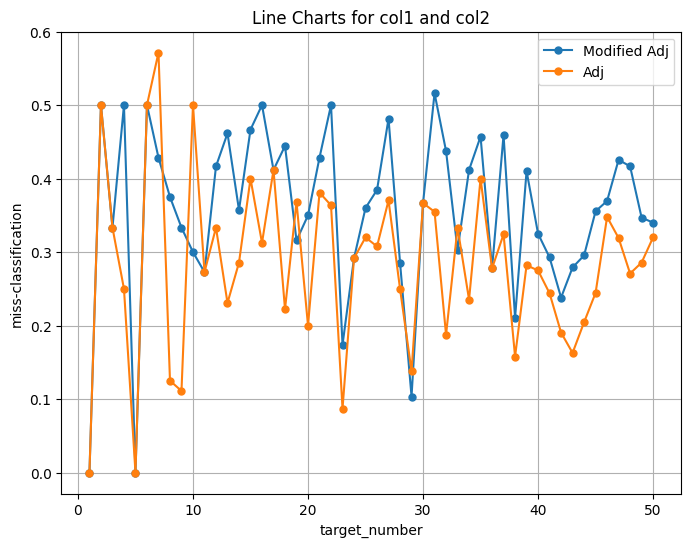

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_1['target_number'], df_1['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# Line chart for col2
plt.plot(df_2['target_number'], df_2['miss-classification'], label='Adj', marker='o', markersize=5, linestyle='-')

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1 and col2')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
budget_range = 50

acc_list = []
acc_node = {}
acc_list_2 = []
acc_node_2 = {}

target_number = 25
node_list = random.sample(list(idx_unlabeled), target_number)

for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        modified_adj = modify_adj(target_node, adj, budget)
        accuracy = evaluate(model, features, modified_adj, labels, target_node)

        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[budget] = curr_acc
    acc_list.append([budget, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

cnt = 0
curr_acc = {1:[], 0:[]}
for target_node in node_list:
    accuracy = evaluate(model, features, adj, labels, target_node)

    if accuracy == 0:
        curr_acc[0].append(target_node)
        cnt += 1
    else:
        curr_acc[1].append(target_node)


acc_node_2[target_number] = curr_acc
acc_list_2.append([target_number, cnt / len(node_list), node_list])

print('Miss-classification rate : %s' % (cnt / len(node_list)))

For budget number: 1
removed 0 edges.
added 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 0 edges.
added 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
Total Target: 25
Miss-classification rate Modified : 0.36
For budget number: 2
removed 0 edges.
added 1 edges.
removed 0 edges.
added 2 edges.
removed 2 edges.
removed 2 edges.
removed 2 edges.
removed 0 edges.
added 2 edges.
removed 2 edges.
removed 2 edges.
removed 0 edges.
added 2 edges.
removed 0 edges.
added 2 edges.
removed 0 edges.
added 2 edges.
removed 2 edges.
removed 0 edges.
added 2 edges.
removed 0 edge

In [ ]:
df_3 = pd.DataFrame(acc_list, columns =['budget_number', 'miss-classification_modified', 'node_list'])
df_3.head()

,budget_number,miss-classification_modified,node_list
0,1,0.36,"[2325, 2691, 2133, 1740, 144, 1836, 2004, 1996..."
1,2,0.40,"[2325, 2691, 2133, 1740, 144, 1836, 2004, 1996..."
2,3,0.44,"[2325, 2691, 2133, 1740, 144, 1836, 2004, 1996..."
3,4,0.44,"[2325, 2691, 2133, 1740, 144, 1836, 2004, 1996..."
4,5,0.44,"[2325, 2691, 2133, 1740, 144, 1836, 2004, 1996..."


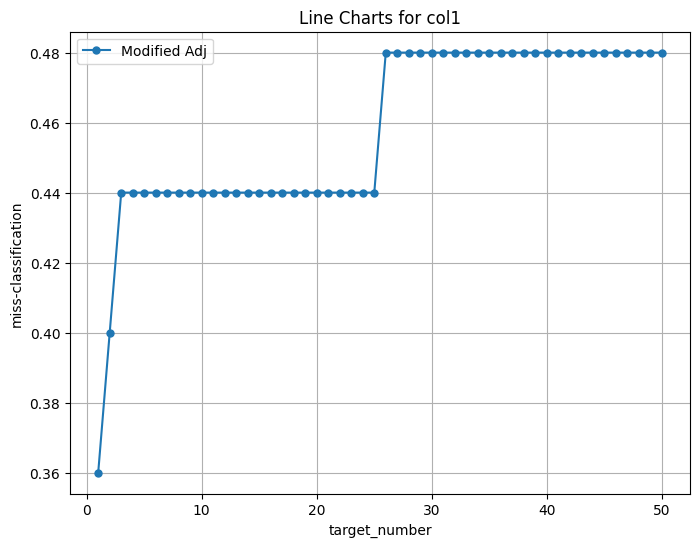

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_3['budget_number'], df_3['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
budget_range = 10

acc_list = []
acc_node = {}
acc_list_2 = []
acc_node_2 = {}

target_number = 10
node_list = random.sample(list(idx_unlabeled), target_number)

for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        modified_adj = modify_adj(target_node, adj, budget)
        accuracy = evaluate(model, features, modified_adj, labels, target_node)

        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[budget] = curr_acc
    acc_list.append([budget, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

cnt = 0
curr_acc = {1:[], 0:[]}
for target_node in node_list:
    accuracy = evaluate(model, features, adj, labels, target_node)

    if accuracy == 0:
        curr_acc[0].append(target_node)
        cnt += 1
    else:
        curr_acc[1].append(target_node)


acc_node_2[target_number] = curr_acc
acc_list_2.append([target_number, cnt / len(node_list), node_list])

print('Miss-classification rate : %s' % (cnt / len(node_list)))

For budget number: 1
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 1 edges.
removed 0 edges.
added 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
removed 1 edges.
Total Target: 10
Miss-classification rate Modified : 0.2
For budget number: 2
removed 2 edges.
removed 0 edges.
added 2 edges.
removed 2 edges.
removed 2 edges.
removed 0 edges.
added 2 edges.
removed 2 edges.
removed 2 edges.
removed 2 edges.
removed 2 edges.
removed 2 edges.
Total Target: 10
Miss-classification rate Modified : 0.1
For budget number: 3
removed 3 edges.
removed 0 edges.
added 3 edges.
removed 3 edges.
removed 3 edges.
removed 0 edges.
added 3 edges.
removed 3 edges.
removed 3 edges.
removed 3 edges.
removed 3 edges.
removed 3 edges.
Total Target: 10
Miss-classification rate Modified : 0.1
For budget number: 4
removed 4 edges.
removed 0 edges.
added 4 edges.
removed 4 edges.
removed 4 edges.
removed 0 edges.
added 4 edges.
removed 4 edges.
removed 4 edg

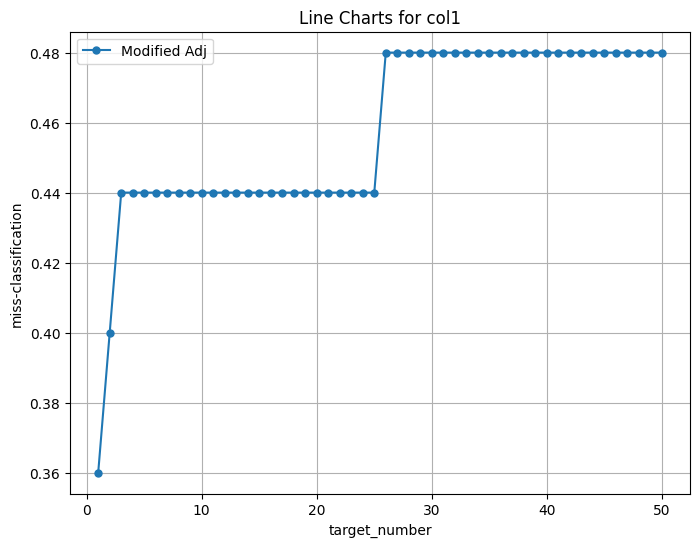

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_3['budget_number'], df_3['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()